In [462]:
from google.colab import drive
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.inspection import permutation_importance

data=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/lol.xlsx")
df=pd.DataFrame(data)
df=df.drop(["Турнир"],axis=1)
ohe_df = pd.get_dummies(df[["Национальность","Позиция на поле","Лига","Клуб"]])
df = pd.concat([df, ohe_df],axis=1)
df=df.drop(["Национальность","Позиция на поле","Лига","Клуб"],axis=1)
#Получаем вроде бы готовый DF для последующей работы
df






,Unnamed: 0,Фамилия Имя,Возраст игрока,Стоимость,Минут на поле в розыгрыше,Голы,Голевые пасы,Голы+голевые пасы,Прогресивный перенос,Прогрессивный пас,...,Клуб_Наполи,Клуб_Ньюкасл Юнайтед,Клуб_ПСВ Эйндховен,Клуб_Пари Сен-Жермен,Клуб_Порту,Клуб_РБ Лейпциг,Клуб_Реал Мадрид,Клуб_Реал Сосьедад,Клуб_Ред Булл Зальцбург,Клуб_Фейеноорд Роттердам
0,0,Kylian Mbappé,25,180,900,8,0,8,65,56,...,False,False,False,True,False,False,False,False,False,False
1,1,Erling Haaland,23,180,776,6,1,7,7,11,...,False,False,False,False,False,False,False,False,False,False
2,2,Jude Bellingham,20,180,742,4,4,8,29,56,...,False,False,False,False,False,False,True,False,False,False
3,3,Bukayo Saka,22,130,720,4,4,8,41,22,...,False,False,False,False,False,False,False,False,False,False
4,4,Phil Foden,23,130,681,5,4,9,23,53,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,177,Fredrik Aursnes,28,20,540,0,1,1,10,24,...,False,False,False,False,False,False,False,False,False,False
178,178,Álvaro Morata,31,20,665,5,1,6,12,6,...,False,False,False,False,False,False,False,False,False,False
179,179,Oscar Gloukh,20,20,476,2,1,3,16,25,...,False,False,False,False,False,False,False,False,True,False
180,180,Miguel Almirón,30,20,413,1,1,2,18,23,...,False,True,False,False,False,False,False,False,False,False


Почему не стал удалять выбросы писал то ли в readme, то ли в проверказх гипотез


Я тут пытался корреляцию считать,но с нйе все не так хорошо получается ,из-за того что ,возможно данных не так много,а возможно ,потому что,нет никого кто бы мог забить 100 голов за 16 матчей



In [463]:
X=df.drop(["Фамилия Имя","Коэффициент успешных прогрессивных пасов","Коэффициент неудачных прогрессивных пасов за минуту","Коэффициент прогрессивных пасов за минуту","Коэффициент прогрессивных переносов за минуту","Unnamed: 0"],axis=1)
y=df["Стоимость"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print( X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)



(145, 85) (145,)
(37, 85) (37,)


Тут вроде с кайфом поделили выборку на тестовую и тренировочную


In [464]:
def mae(y_true, y_pred):
    return (mean_absolute_error(y_true, y_pred))
model=LinearRegression()
model.fit(X_train,y_train)
y_pred_LR=model.predict(X_test)
y_pred_test=model.predict(X_train)
mae_lr = mae(y_test, y_pred_LR)
mae_lr_train=mae(y_train,y_pred_test)


print(mae_lr.round(3))
print(mae_lr_train.round(3))




0.0
0.0


In [465]:
def plot_yreal_ypred(y_real, y_pred,title=""):
    plt.figure(figsize=(16, 9))
    plt.scatter(y_real, y_pred)
    plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], color='black', linestyle='-')

    plt.title(title)
    plt.xlabel('Реальные')
    plt.ylabel('Предсказанные')
    plt.show()
# сохраним функцию дял графика предсказанных и реальных значений


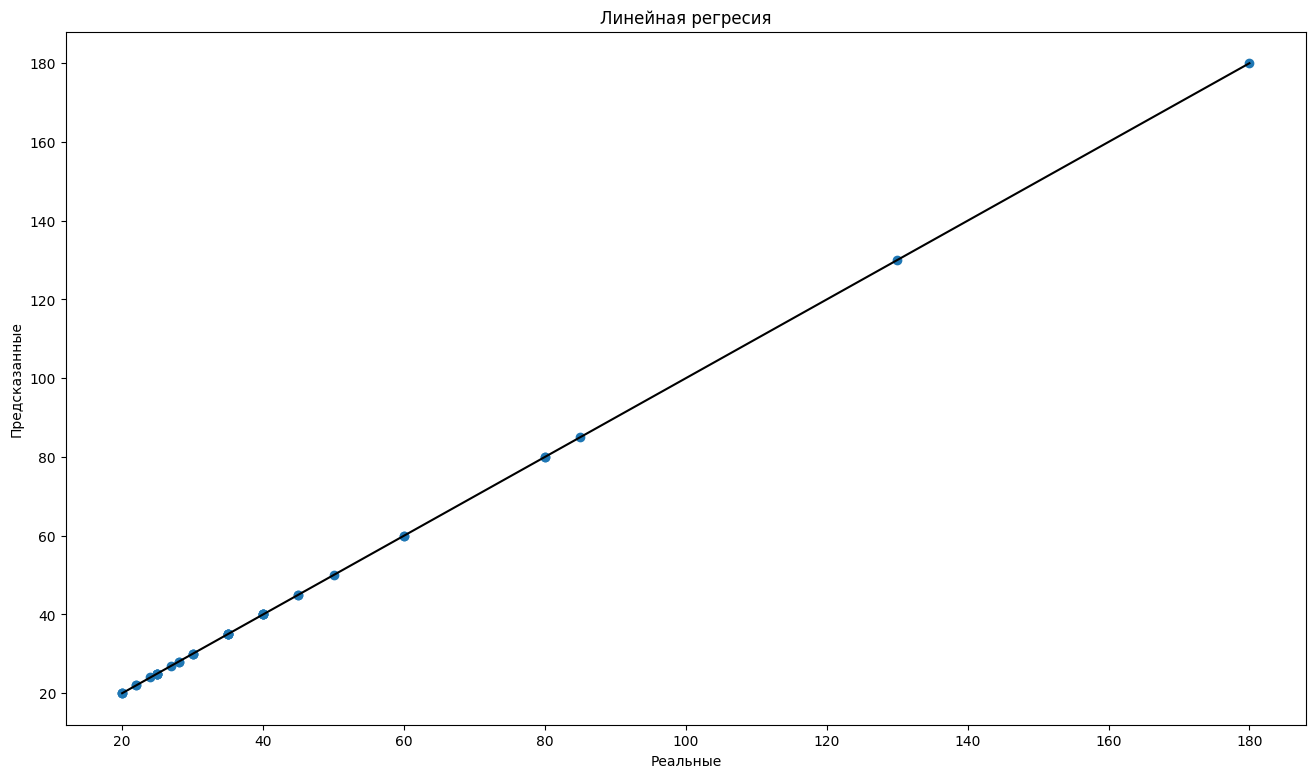

None


In [466]:

print(plot_yreal_ypred(y_test, y_pred_LR, title='Линейная регресия'))


Модель идеальна легендарна ,и невероястно круто предсказывает стоимость игроков ,сказать о том ,что модель переобучилась скорее всего нельзя так как ,на тренировочной выборке показывает почти нулевое отклонеие от реальных значений,значит скорее всего можно сказать,что прсото модель предсказывает идеально данные


Ппосмотрим как будет работать дерево решений для модели


Accuracy: 0.8648648648648649
MAE0.4594594594594595
MAE0.0


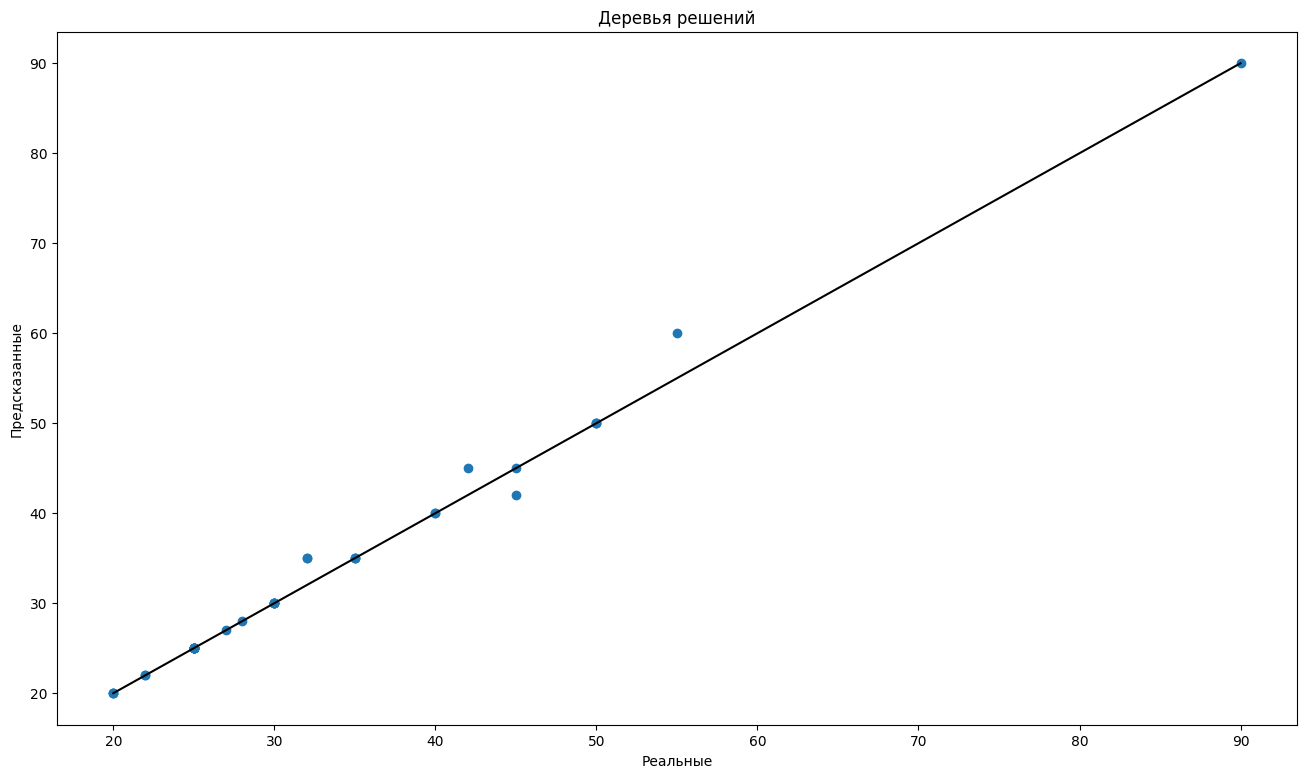

None


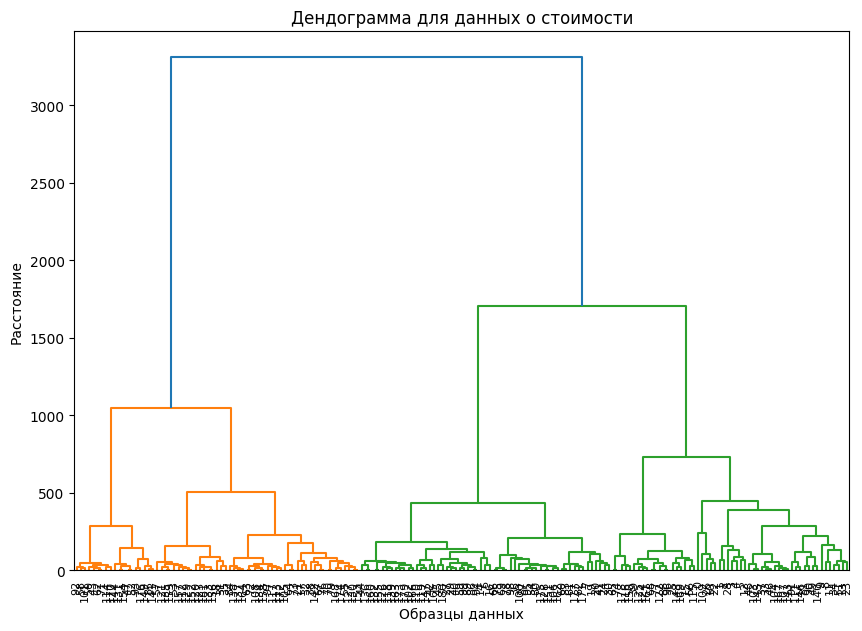

In [467]:
target_column = "Стоимость"
drop_columns = [ "Фамилия Имя", "Коэффициент успешных прогрессивных пасов",
                "Коэффициент неудачных прогрессивных пасов за минуту",
                "Коэффициент прогрессивных пасов за минуту",
                "Коэффициент прогрессивных переносов за минуту","Unnamed: 0"]


y = df[target_column]
X = df.drop(drop_columns, axis=1)


X_train_AC, X_test_AC, y_train_AC, y_test_AC = train_test_split(X, y, test_size=0.2)


clf = DecisionTreeClassifier()


clf.fit(X_train_AC, y_train_AC)


y_pred_AC = clf.predict(X_test_AC)
y_pred_train=clf.predict(X_train_AC)


accuracy_test = accuracy_score(y_test_AC, y_pred_AC)
#с кайфом выводим резльутаты

print(f"Accuracy: {accuracy_test}")
print(f"MAE{mae(y_test_AC,y_pred_AC)}")
print(f"MAE{mae(y_train_AC,y_pred_train)}")
print(plot_yreal_ypred(y_test_AC, y_pred_AC, title='Деревья решений'))



Z = linkage(X, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df.index, leaf_rotation=90, leaf_font_size=8)
plt.title('Дендограмма для данных о стоимости')
plt.xlabel('Образцы данных')
plt.ylabel('Расстояние')
plt.show()


Тут тоже моделька очень круто предсказывает и получается ,потом я проверил на тренировочной выборе и MAE тоже получился нулевым=> это значит скорее всего что модель опять предсказывает почти идеально ,как гений <как крутая гениальная шука.На дендограмме видно ,что данные разделеные на два основных класстера зеленый и оранжевый .Мы бы моггли на уровне 1500 провести горизонтальную линию и разделить данные на 3-4 основных кластера


11.243243243243244


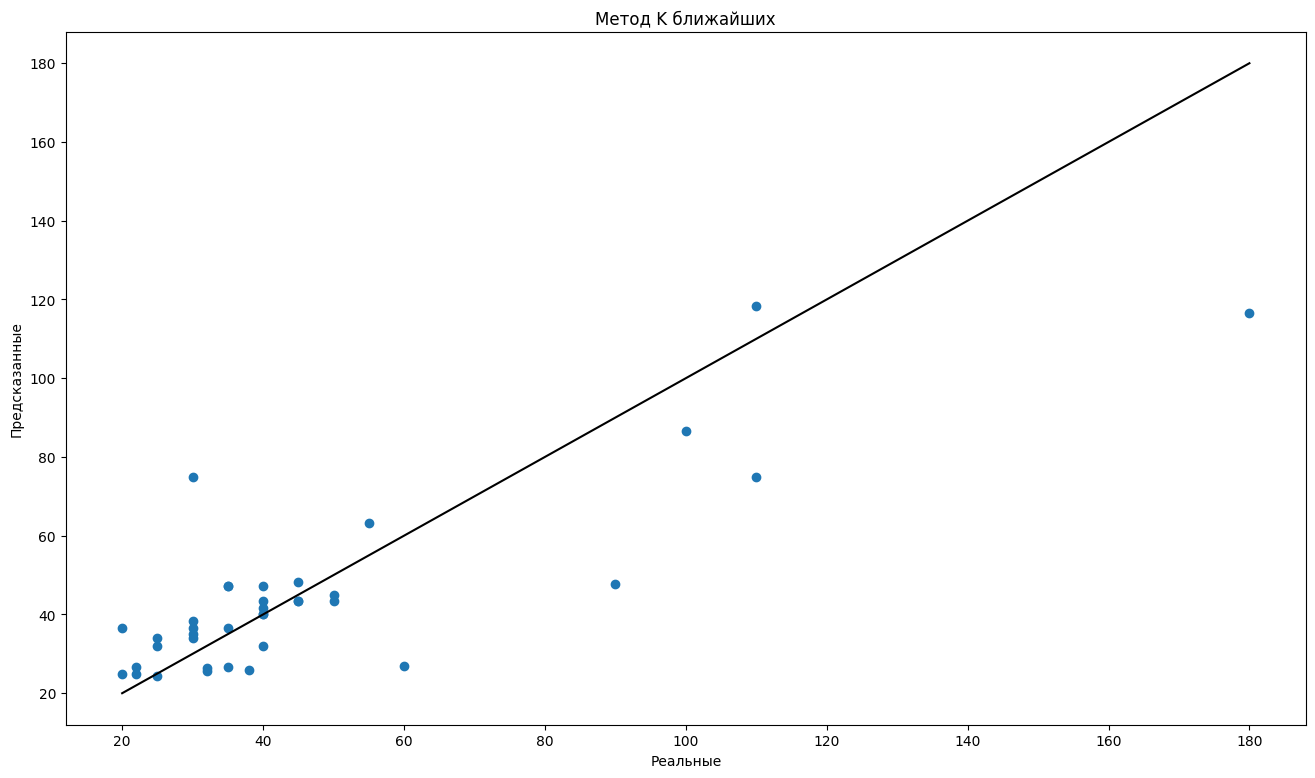

None


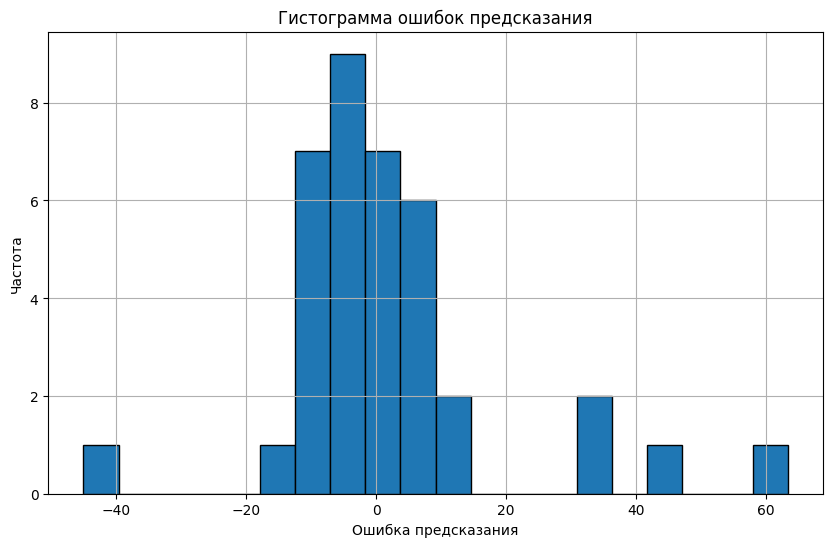

In [468]:
X_train_K, X_test_K, y_train_K, y_test_K = train_test_split(X, y, test_size=0.2)
regressor = KNeighborsRegressor(n_neighbors=3)
regressor.fit(X_train_K, y_train_K)
y_pred_K = regressor.predict(X_test_K)


print(mae(y_test_K, y_pred_K))


print(plot_yreal_ypred(y_test_K, y_pred_K, title='Метод K ближайших'))



errors = y_test_K - y_pred_K
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, edgecolor='black')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Гистограмма ошибок предсказания')
plt.grid(True)
plt.show()





Большинство ошибок лежат в пределах от -20 до 15, что говорит о том, что предсказания модели в основном близки к реальным значениям.
Пик гистограммы где то  около 0, что вроде как говорит , что для большинства данных предсказания модели близки к факт. значениям.Если бы ошибки были сосредоточены в положительной значениях, это означало бы, что модель систематически переоценивает значения,а так вроде все норм,местами переоценивает,местам и недооценивает,но в целом вроде норм работает

Тут тоже моделька тоже в целом достаточно хорошо предсказывает,но уже меньше покожа на переобученную,но в целом все еще хорошо предсказывает ,ошибка достаточно маленькая,а график прикольный


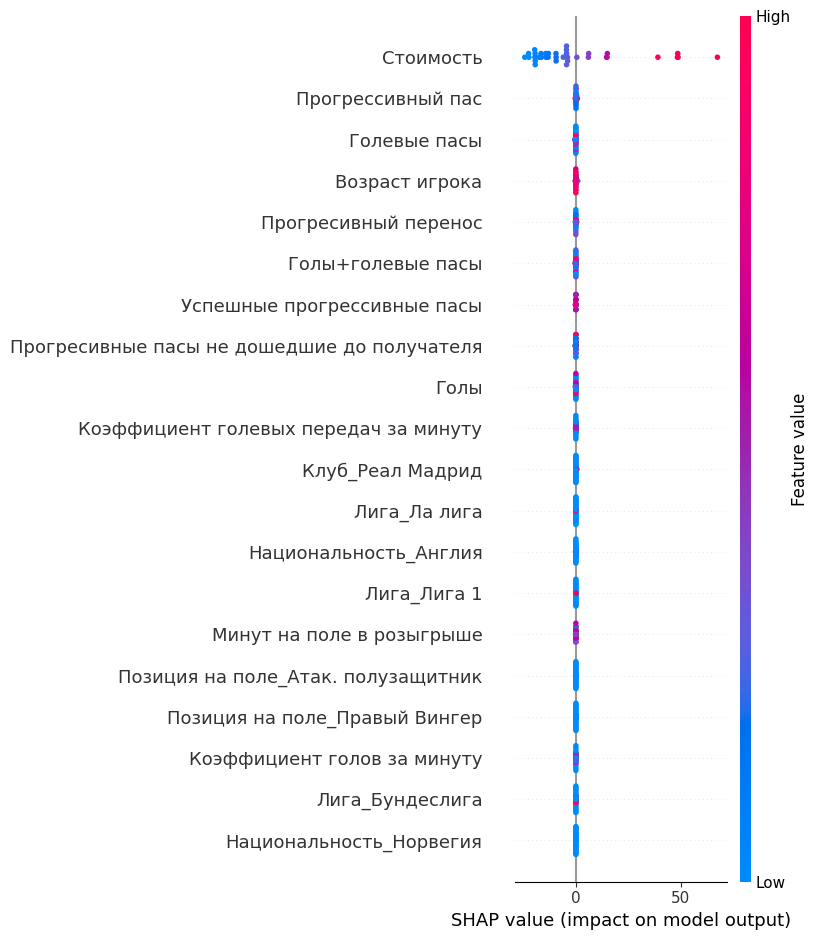

In [469]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
model = RandomForestRegressor(random_state=42)
model.fit(X_train_F, y_train_F)

explainer = shap.Explainer(model)
shap_values = explainer(X_test_F)

#Вроде тут с кайфом выодит все
shap.summary_plot(shap_values, X_test_F)

У меян было предположение,что больше всего на на стоимость игрока влияет именно его возраст(отрицательно влияет),но тут вроде кк получается что больше всего влияет именно его атакующая составляющая ,то есть прогрессивные пасы и голевые пасы , и два этих фактора положительно влияют на стоимость.В то время как возраст только на третьем месте и отрицательно влияе на стоимость игрока .Так же интересным наблоюдением можно заметить,что если игрок играе в Реале , то скорее всего это какой-то топовый игрок с высокой стоимостью, а так же это касается испаснкой Ло лиги в целом .Так же можно заметить,что английские игроки чаще всего дорого стоят.